In [1]:
import math
import random
from datetime import timedelta, datetime
import pandas as pd
import numpy as np
import scipy.stats as ss
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from itertools import combinations
import time
from datetime import date, datetime

from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import BaseCrossValidator

import yfinance as yf
import tensorflow as tf

from backtesting import Strategy, Backtest
from backtesting.lib import crossover
from skopt.plots import plot_objective

/opt/anaconda3/lib/python3.7/site-packages/backtesting/_plotting.py:45: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
d = date.today().strftime("%d%m%Y")
d

'28032021'

In [3]:
date_time_obj = datetime.strptime(d, '%d%m%Y')

In [4]:
date_time_obj

datetime.datetime(2021, 3, 28, 0, 0)

In [5]:
from talib import abstract
from talib import MA_Type

## Backtesting Strategies
Additional info: https://kernc.github.io/backtesting.py/doc/examples/Quick%20Start%20User%20Guide.html

In [6]:
import inspect
import strats, get_data, backtest
from typing import Tuple

In [7]:
stock_obj = get_data.yFinData("SPY")
try:
    ydata = stock_obj.get_ohlcv()
except:
    print('Uable to download data.')

In [59]:
def get_back_test_comparasion(ydata: pd.DataFrame, strategy: str, data_range, strategy_params: dict,
                              cash: int=1_000_000, commission: float=0.):
    """
    backtest vs buy/hold strategy in strats.py
    input: stock OHLCV dataframe
    output: dataframe of strategy returns, dictionary of trades and equity curve
    """
    avail_strats = [obj for name, obj in inspect.getmembers(strats, inspect.isclass) 
                    if (obj.__name__ == strategy) or (obj.__name__ == "BuyAndHold")]
    if not data_range.isdecimal():
        corresponding = {"6m":0.5, "1y":1., "2y":2.}
        data = ydata.iloc[-int(float(corresponding[data_range])*252):]
    else:
        data = ydata.loc["{}-12-31".format(int(data_range)-1):"{}-12-31".format(int(data_range)),]
    
    temp = []
    sname_temp = []
    equity_trades = {}
    for s in avail_strats:
        if data.shape[0] == 0:
            continue

        bt = Backtest(data, s, cash=cash, commission=commission)
        if s.__name__ == 'SmaCross':
            stats = bt.run(slow = strategy_params['slow'],
                           fast = strategy_params['fast'],
                           long_only = strategy_params['long_only'])
        elif s.__name__ == 'MacdSignal':
            stats = bt.run(fastperiod = strategy_params['fastperiod'],
                           slowperiod = strategy_params['slowperiod'],
                           signalperiod = strategy_params['signalperiod'],
                           long_only = strategy_params['long_only'])
        elif s.__name__ == 'StochOsci':
            stats = bt.run(fastk_period = strategy_params['fastk_period'],
                           slowk_period = strategy_params['slowk_period'],
                           slowd_period = strategy_params['slowd_period'],
                           overbought = strategy_params['overbought'],
                           oversold = strategy_params['oversold'],
                           long_only = strategy_params['long_only'])
        elif s.__name__ == 'StochRsi':
            stats = bt.run(timeperiod = strategy_params['timeperiod'],
                           fastk_period = strategy_params['fastk_period'],
                           slowk_period = strategy_params['slowk_period'],
                           slowd_period = strategy_params['slowd_period'],
                           overbought = strategy_params['overbought'],
                           oversold = strategy_params['oversold'],
                           long_only = strategy_params['long_only']) 
        else:
            stats = bt.run()
        sname = str(stats["_strategy"])
        sname_temp.append("{}_{}".format(sname, data_range))
        temp.append(stats[:27])
        equity_trades["{}_{}".format(sname, data_range)] = (stats["_equity_curve"], stats["_trades"])

    strat_returns = pd.concat(temp, axis=1)
    strat_returns.columns = sname_temp
    return strat_returns

In [61]:
strat_returns = get_back_test_comparasion(ydata, 'SmaCross', "2013", {'slow':10, 'fast':20, 'long_only':1}, 1_000_000, 0.)

<class 'strats.BuyAndHold'>
<class 'strats.SmaCross'>


In [62]:
strat_returns

,BuyAndHold_2013,"SmaCross(slow=10,fast=20,long_only=1)_2013"
Start,2012-12-31 00:00:00,2012-12-31 00:00:00
End,2013-12-31 00:00:00,2013-12-31 00:00:00
Duration,365 days 00:00:00,365 days 00:00:00
Exposure Time [%],99.2095,26.8775
Equity Final [$],1.29062e+06,1.15938e+06
Equity Peak [$],1.29062e+06,1.15938e+06
Return [%],29.0624,15.9377
Buy & Hold Return [%],32.3078,32.3078
Return (Ann.) [%],28.9324,15.87
Volatility (Ann.) [%],13.9463,7.75976


## CPCV

In [8]:
class CPCV(BaseCrossValidator):
    # TODO: add purge "holes" !!!
    def __init__(self, X, N, k):
        self.X = X
        self.N = N
        self.k = k

    def generate_eras(self):
        # assuming exact division, we will cut-off small piece of time series
        # in the very beginning
        return np.array(sum([
                    [i] * (len(self.X) // self.N) for i in range(self.N)
                    ], []
                   )
        )
        
    def split(self, X=None, y=None, groups=None):
        # removing first m items from time series
        eras = self.generate_eras()
        len_diff = abs(len(self.X) - len(eras))
        comb = list(combinations(range(self.N), self.N-self.k))
        all_splits = range(self.N)

        for combination in comb:
            train_indices, test_indices = [], []
            for c in combination:
                indices_train = list(np.where(eras == c)[0])
                train_indices.extend(indices_train)
            for t in list(set(all_splits) - set(combination)):
                indices_test = list(np.where(eras == t)[0])
                test_indices.extend(indices_test)
            yield(train_indices, test_indices)  
              
    def get_n_splits(self):
        comb = combinations(range(self.N), self.N-self.k)
        return len(list(comb))

In [9]:
N = 6
k = 2
comb = combinations(range(N), N-k)
for e, c in enumerate(list(comb)): 
    print(e+1, c)

1 (0, 1, 2, 3)
2 (0, 1, 2, 4)
3 (0, 1, 2, 5)
4 (0, 1, 3, 4)
5 (0, 1, 3, 5)
6 (0, 1, 4, 5)
7 (0, 2, 3, 4)
8 (0, 2, 3, 5)
9 (0, 2, 4, 5)
10 (0, 3, 4, 5)
11 (1, 2, 3, 4)
12 (1, 2, 3, 5)
13 (1, 2, 4, 5)
14 (1, 3, 4, 5)
15 (2, 3, 4, 5)


In [40]:
def macd_reliability(ydata, N=6, k=2):
    ydata = ydata.iloc[-int(float(5)*252):-1]
    cpcv = CPCV(ydata, N, k)
    train_temp = []
    test_temp = []
    NSAMPLES = 5
    for e, (train_ids, test_ids) in enumerate(cpcv.split()):
        dataset_train, dataset_test = ydata.iloc[train_ids], ydata.iloc[test_ids]
        train, test = [], []
        bt = Backtest(dataset_train, strats.MacdSignal, cash=10_000, commission=0.0)
        for i in range(NSAMPLES):
            stats_skopt, heatmap, optimize_result = bt.optimize(
                fastperiod = [5, 50],
                slowperiod = [10, 60],
                signalperiod = [5, 20],
                constraint=lambda p: p.signalperiod < p.fastperiod < p.slowperiod,
                maximize='Sharpe Ratio',
                method='skopt',
                max_tries=30,
                return_heatmap=True,
                return_optimization=True)
            btopt = Backtest(dataset_test, strats.MacdSignal, cash=10_000, commission=0.0)
            optstats = btopt.run(fastperiod = optimize_result.x[0], slowperiod = optimize_result.x[1], signalperiod = optimize_result.x[2])
            train.append(stats_skopt)
            test.append(optstats)
        train_temp.append(train)
        test_temp.append(test)
    train_stats = [pd.concat(train, axis=1) for train in train_temp]
    test_stats = [pd.concat(test, axis=1) for test in test_temp]
    return train_stats, test_stats

In [41]:
train_stats, test_stats = macd_reliability(ydata)

KeyboardInterrupt: 

In [ ]:
def gather_sims(train_stats, test_stats):
    display = ['Return (Ann.) [%]', 'Exposure Time [%]', 'Win Rate [%]',
               '# Trades', 'Volatility (Ann.) [%]', 'Max. Drawdown [%]',
               'Sharpe Ratio', 'Sortino Ratio', 'Calmar Ratio']
    train_dict = {}
    test_dict = {}
    for d in display:
        train_collected = []
        test_collected = []
        for train, test in zip(train_stats, test_stats):
            train_data = train.loc[d,:].to_numpy()
            test_data = test.loc[d,:].to_numpy()
            train_collected = np.concatenate((train_collected, train_data), axis=None)
            test_collected = np.concatenate((test_collected, test_data), axis=None)
        train_dict[d] = train_collected
        test_dict[d] = test_collected

    return pd.DataFrame(train_dict), pd.DataFrame(test_dict)

train_df, test_df = gather_sims(train_stats, test_stats)

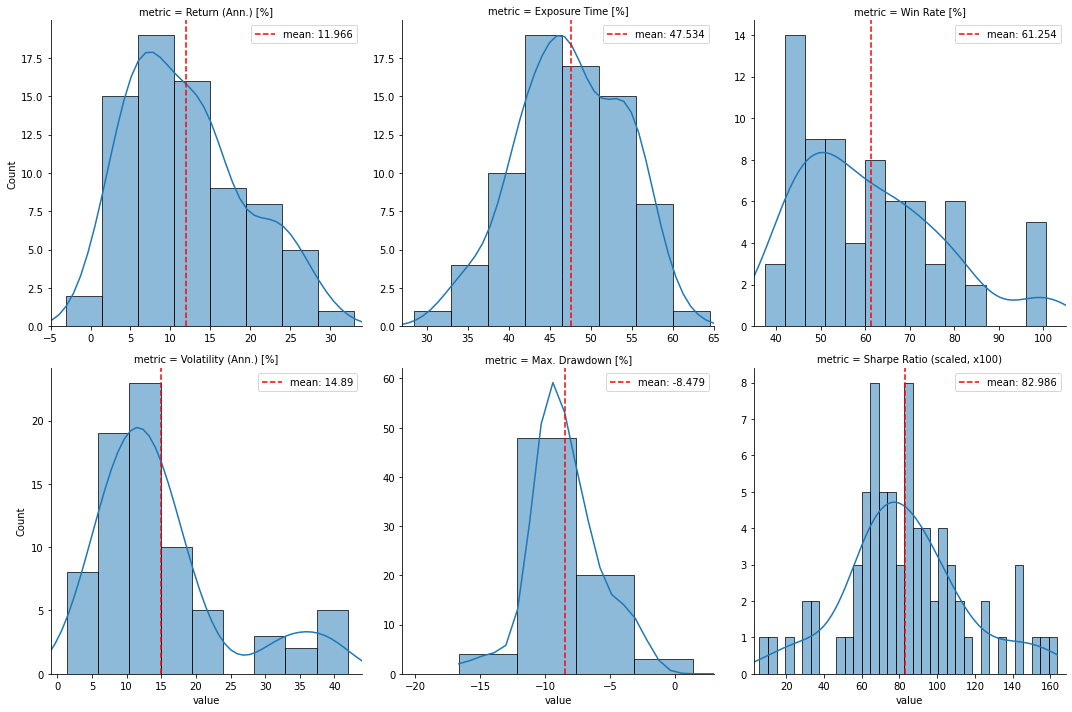

In [105]:
def visualize(df, tt, ticker, strategy):
    df['Sharpe Ratio (scaled, x100)'] = df['Sharpe Ratio'] * 100
    display = ['Return (Ann.) [%]', 'Exposure Time [%]', 'Win Rate [%]',
               'Volatility (Ann.) [%]', 'Max. Drawdown [%]',
               'Sharpe Ratio (scaled, x100)']
    dfl = df.loc[:,display].stack().reset_index(level=1).rename(columns={'level_1':'metric', 0:'value'})
    dfl = dfl.astype({'value':'float64'})
    df  = df.loc[:,display]
    g = sns.displot(data=dfl, x='value', col='metric', bins=40, kde=True, col_wrap=3, facet_kws={'sharex':False, 'sharey':False})
    for i, ax in enumerate(g.axes.flat): # set every-other axis for testing purposes
        mini = df.iloc[:,i].min()
        maxi = df.iloc[:,i].max()
        mean = df.iloc[:,i].mean()
        ax.axvline(mean, ls = '--', color = 'red', label = "mean: {}".format(round(mean, 3)))
        ax.set_xlim(int(mini)-5,int(maxi)+5)
        ax.legend()
    
    tmpfile = BytesIO()
    g.savefig(tmpfile, format='png')
    encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')
    html = '<img src=\'data:image/png;base64,{}\'>'.format(encoded)
    filename = "./reliability_plots/"+ ticker + "_" + strategy + "_" + tt ".html"
    with open(filename,'w') as f:
        f.write(html)

plot = visualize(test_df, "TEST", "SPY", "MacdSignal")

In [63]:
tickers = ['SPY', 'QQQ', 'EEM', 'AAPL', 'MSFT', 'AMZN', 'FB', 'GOOGL', 'GOOG', 'TSLA']

In [204]:
def calculate_pbo(train_df, test_df):
    w_c_is = train_df['Sharpe Ratio']
    w_c_oos = test_df['Sharpe Ratio']
    n_star = np.argmax(w_c_is)
    n_star, ss.rankdata(w_c_oos)
    w_c = (ss.rankdata(w_c_oos) - n_star) / len(w_c_oos)
    w_c = w_c + np.abs(np.min(w_c))
    y_c = np.log(w_c / (1 - w_c))
    y_c[y_c==-np.inf] = 0
    y_c_neg = y_c[y_c < 0]
    y_c_neg = (y_c_neg - y_c_neg.min()) / (y_c_neg.max() - y_c_neg.min())
    pbo = np.mean(y_c_neg)
    return pbo

In [11]:
pd.DataFrame([[1, 2], [3, 4]], columns=["a", "b"])

,a,b
0,1,2
1,3,4


In [ ]:
import get_data, backtest

def daily_process():
    tickers = ['SPY', 'QQQ', 'EEM', 'AAPL', 'MSFT', 'AMZN', 'FB', 'GOOGL', 'GOOG', 'TSLA']
    strategies = ['SmaCross', 'MacdSignal', 'RsiSignal']
    corresponding_dict = {'SmaCross':backtest.sma_reliability, 
                      'MacdSignal':backtest.macd_reliability,
                      'RsiSignal':backtest.rsi_reliability}
    for ticker in tickers:
        stock_obj = get_data.yFinData(ticker)
        try:
            data = stock_obj.get_ohlcv()
        except:
            print('Uable to download data.')
        pbos = []
        for strategy in strategies:
            reliability_test = corresponding_dict[strategy]
            train_stats, test_stats = reliability_test(data)
            train_df, test_df = backtest.gather_sims(train_stats, test_stats)
            backtest.visualize(train_df, "TRAIN", ticker, strategy), backtest.visualize(test_df, "TEST", ticker, strategy)
            backtest.corr_plot(train_df, test_df, ticker, strategy)
            pbo = backtest.calculate_pbo(train_df, test_df)
            pbos.append([strategy, pbo])
        pbos = pd.DataFrame(pbos, columns=["strategy", "pbo"])
        pbos["datetime"] = date.today().strftime("%d/%m/%Y")
        pbos.to_csv("reliability_pbo/{}_pbo.csv".format(ticker), index=False)

daily_process()

/Users/lesterpjy/Desktop/Berkeley/sem_5/capstone/capstone_indicators/backtest.py:311: RuntimeWarning: divide by zero encountered in log
  y_c = np.log(w_c / (1 - w_c))
/Users/lesterpjy/Desktop/Berkeley/sem_5/capstone/capstone_indicators/backtest.py:311: RuntimeWarning: divide by zero encountered in true_divide
  y_c = np.log(w_c / (1 - w_c))
/Users/lesterpjy/Desktop/Berkeley/sem_5/capstone/capstone_indicators/backtest.py:311: RuntimeWarning: invalid value encountered in log
  y_c = np.log(w_c / (1 - w_c))
/Users/lesterpjy/Desktop/Berkeley/sem_5/capstone/capstone_indicators/backtest.py:311: RuntimeWarning: divide by zero encountered in log
  y_c = np.log(w_c / (1 - w_c))
/Users/lesterpjy/Desktop/Berkeley/sem_5/capstone/capstone_indicators/backtest.py:311: RuntimeWarning: divide by zero encountered in log
  y_c = np.log(w_c / (1 - w_c))
/Users/lesterpjy/Desktop/Berkeley/sem_5/capstone/capstone_indicators/backtest.py:311: RuntimeWarning: divide by zero encountered in log
  y_c = np.log(w_

In [22]:
import os
def read_files(ticker, strategy):
    def get_file(file):
        with open(file, 'r') as f:
            data = f.read().replace('\n', '')
        return data
    starts = ticker + "_" + strategy
    folder = "reliability_plots"
    for filename in os.listdir(folder):
        root, ext = os.path.splitext(filename)
        if root.startswith(starts) and "TRAIN" in root:
            train = get_file(os.path.join(folder, filename))
        elif root.startswith(starts) and "TEST" in root:
            test = get_file(os.path.join(folder, filename))
        elif root.startswith(starts) and "corr" in root:
            corr = get_file(os.path.join(folder, filename))
    return train, test, corr

In [31]:
pbo_df = pd.read_csv(os.path.join("reliability_pbo", "AAPL" + "_pbo.csv"))
pbo_df.loc[pbo_df["strategy"] == "SmaCross", "pbo"].values[0]

0.6971828088206802

In [213]:
import statsmodels.api as sm

In [219]:
Y = w_c_oos.astype(float)
X = w_c_is.astype(float)
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results = model.fit()

In [220]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Sharpe Ratio   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     55.65
Date:                Wed, 17 Mar 2021   Prob (F-statistic):           1.45e-10
Time:                        20:03:09   Log-Likelihood:                 34.060
No. Observations:                  75   AIC:                            -64.12
Df Residuals:                      73   BIC:                            -59.48
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.6609      0.054     12.154      0.000       0.553       0.769
Sharpe Ratio    -0.9763      0.131     -7.460      0.000      -1.237      -0.715
==============================================================================
Omnibus:                        0.036   Durbin-Watson:                   0.687
Prob(Omnibus):                  0.982   Jarque-Bera (JB):                0.072
Skew:                          -0.042   Prob(JB):                        0.965
Kurtosis:                       2.873   Cond. No.                         8.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [98]:
train = train_df.loc[:,["Sharpe Ratio"]].rename(columns={"Sharpe Ratio":"Sharpe Ratio IS"})
test = test_df.loc[:,["Sharpe Ratio"]].rename(columns={"Sharpe Ratio":"Sharpe Ratio OOS"})
df_temp = train.join(test)
df_temp

,Sharpe Ratio IS,Sharpe Ratio OOS
0,1.33014,0.843945
1,1.29011,0.700729
2,1.5021,0.937773
3,1.4123,0.859695
4,1.2973,0.859695
...,...,...
70,1.12716,0.971855
71,1.04407,1.11076
72,1.0068,1.63633
73,1.05895,1.10123


""
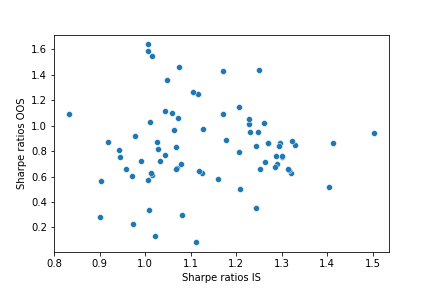

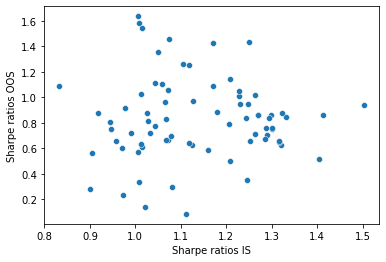

In [102]:
def corr_plot(train_df, test_df, ticker, strategy):
    train = train_df.loc[:,["Sharpe Ratio"]].rename(columns={"Sharpe Ratio":"Sharpe Ratio IS"})
    test = test_df.loc[:,["Sharpe Ratio"]].rename(columns={"Sharpe Ratio":"Sharpe Ratio OOS"})
    df = train.join(test)
    corr = plt.figure()
    sns.scatterplot(data=df, x="Sharpe Ratio IS", y="Sharpe Ratio OOS")
    plt.xlabel('Sharpe ratios IS')
    plt.ylabel('Sharpe ratios OOS')
    
    tmpfile = BytesIO()
    corr.savefig(tmpfile, format='png')
    encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')
    html = '<img src=\'data:image/png;base64,{}\'>'.format(encoded)
    filename = "./reliability_plots/"+ ticker + "_" + strategy + "_corr_" + str(time.time()) + ".html"
    with open(filename,'w') as f:
        f.write(html)
    with open(filename, 'r') as f:
        data = f.read().replace('\n', '')
    return data

corr_plot(train_df, test_df, "SPY", "MacdSignal")

### Some visualizations

In [ ]:
equity_trades['MacdSignal'][1]

In [ ]:
sma_trades['PnL'].hist(bins=30)
sma_trades.loc[:, ['PnL', "EntryTime"]].set_index('EntryTime').plot()

In [ ]:
macd_trades = equity_trades['MacdSignal'][1]
macd_trades['PnL'].hist(bins=30)
macd_trades.loc[:, ['PnL', "EntryTime"]].set_index('EntryTime').plot()

In [ ]:
rsi_trades = equity_trades['RsiSignal'][1]
rsi_trades['PnL'].hist(bins=30)
rsi_trades.loc[:, ['PnL', "EntryTime"]].set_index('EntryTime').plot()

In [ ]:
stoch_trades = equity_trades['StochOsci'][1]
stoch_trades['PnL'].hist(bins=30)
stoch_trades.loc[:, ['PnL', "EntryTime"]].set_index('EntryTime').plot()

In [ ]:
stochrsi_trades = equity_trades['StochRsi'][1]
stochrsi_trades['PnL'].hist(bins=30)
stochrsi_trades.loc[:, ['PnL', "EntryTime"]].set_index('EntryTime').plot()

## Geometric Brownian Motion

In [ ]:
def train_models_to_reconstruct_ohlcv_from_close(data):
    # important note: trained on log data, need to exp later
    data2train = np.log(data[['High', 'Low', 'Open', 'Close', 'Volume']])
    X_prices, Y_prices = data2train['Close'], data2train[['High', 'Low', 'Open']]
    X_volume, Y_volume = data2train[['High', 'Low', 'Open', 'Close']], data2train['Volume']
    
    model_prices = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(3)
        ])
    model_prices.compile('adam', 'mae')
    model_prices.fit(X_prices, Y_prices, epochs=50, verbose=False)
    
    model_volume = tf.keras.models.Sequential([
        tf.keras.layers.Dense(20, activation='relu'),
        tf.keras.layers.Dense(1)
        ])
    model_volume.compile('adam', 'mae')
    model_volume.fit(X_volume, Y_volume, epochs=50, verbose=False)
    return model_prices, model_volume

In [ ]:
model_prices, model_volume = train_models_to_reconstruct_ohlcv_from_close(ydata)

In [ ]:
def convert_to_returns(log_returns):
    """
    This method exponentiates a sequence of log returns to get daily returns.
    """
    return np.exp(log_returns)


def convert_to_prices(log_returns, s0 = 1e-3):
    """
    This method converts a sequence of log returns into normal returns (exponentiation) and then computes a price
    sequence given a starting price, param.all_s0.
    """
    returns = convert_to_returns(log_returns)
    price_sequence = [s0]
    for i in range(1, len(returns)):
        price_sequence.append(price_sequence[i - 1] * returns[i - 1])
    return np.array(price_sequence)

In [ ]:
def brownian_motion_log_returns(delta, sigma, N):
    """
    This method returns a Wiener process. The Wiener process is also called Brownian motion. For more information
    about the Wiener process check out the Wikipedia page: http://en.wikipedia.org/wiki/Wiener_process
    """
    sqrt_delta_sigma = math.sqrt(delta) * sigma
    return np.random.normal(loc=0, scale=sqrt_delta_sigma, size=N)

In [ ]:
def geometric_brownian_motion_log_returns(delta, mu, sigma, N):
    """
    This method constructs a sequence of log returns which, when exponentiated, produce a random Geometric Brownian
    Motion (GBM). GBM is the stochastic process underlying the Black Scholes options pricing formula.
    """
    wiener_process = np.array(brownian_motion_log_returns(delta, sigma, N))
    sigma_pow_mu_delta = (mu - 0.5 * math.pow(sigma, 2.0)) * delta
    return wiener_process + sigma_pow_mu_delta

In [ ]:
def jump_diffusion_process(delta, lamda, jumps_mu, jumps_sigma, N):
    """
    This method produces a sequence of Jump Sizes which represent a jump diffusion process. These jumps are combined
    with a geometric brownian motion (log returns) to produce the Merton model.
    """
    s_n = time = 0
    small_lamda = -(1.0 / lamda)
    jump_sizes = []
    for k in range(0, N):
        jump_sizes.append(0.0)
    while s_n < N:
        s_n += small_lamda * math.log(np.random.uniform(0, 1))
        for j in range(0, N):
            if time * delta <= s_n * delta <= (j + 1) * delta:
                # print("was true")
                jump_sizes[j] += random.normalvariate(jumps_mu, jumps_sigma)
                break
        time += 1
    return jump_sizes


def geometric_brownian_motion_jump_diffusion_log_returns(delta, mu, sigma, lamda, jumps_mu, jumps_sigma, N):
    """
    This method constructs combines a geometric brownian motion process (log returns) with a jump diffusion process
    (log returns) to produce a sequence of gbm jump returns.
    """
    jump_diffusion = jump_diffusion_process(delta, lamda, jumps_mu, jumps_sigma, N)
    geometric_brownian_motion = geometric_brownian_motion_log_returns(delta, mu, sigma, N)
    return np.add(jump_diffusion, geometric_brownian_motion)

In [ ]:
ydata.Close.plot()

In [ ]:
# x = brownian_motion_log_returns(1, 0.000001, 1000)
# x = geometric_brownian_motion_log_returns(1, 0, 0.0312, 1000)

# delta, mu, sigma, lamda, jumps_mu, jumps_sigma, N
def simulate(data):
    mm, sstd = data.Close.pct_change().mean(), data.Close.pct_change().std()
    x = geometric_brownian_motion_jump_diffusion_log_returns(1, mm, sstd, 0.1, -0.01, 0.001, 1000)
    prices_simulation = convert_to_prices(x, 100)
    hlo_simulated = model_prices.predict(np.log(prices_simulation))
    hloc_simulated = np.concatenate((np.exp(hlo_simulated), np.expand_dims(prices_simulation, -1)), axis=1)
    volume_simulated = np.exp(model_volume.predict(np.log(hloc_simulated)))
    dataset_simulated = pd.DataFrame({
        'High': hloc_simulated[:, 0],
        'Open': hloc_simulated[:, 1],
        'Low': hloc_simulated[:, 2],
        'Close': hloc_simulated[:, 3],
        'Volume': volume_simulated.flatten()
    },
        index = [datetime.today() + timedelta(days=x) for x in range(len(hloc_simulated))])
    return dataset_simulated

In [ ]:
dataset_simulated = simulate(ydata)
dataset_simulated[['High', 'Low', 'Open', 'Close']].plot()